# CEO-REQUEST CHALLENGE

***CEO Question***

How do we increase customer satisfaction (so as to increase profit margins) while maintaining a healthy order volume?

**Findings from our Preliminary Analysis of the Orders and Sellers Datasets**


- The more sellers (`number_of_sellers`) and products (`number_of_products`) that are combined into a single order, the lower the order `review_score`.  
- The `wait_time` for the order, which is made up of two components (seller's `delay_to_carrier` + `carrier_delivery_time`) also has a significant association with low review scores.  
- When these features are examined on a per seller basis, we can see that they still have an impact review score, and further we're able to identify which sellers are linked with lower review scores

While orders that contain more than a single seller or product do have a significant association with low review scores, these types of orders do not make up a large part of the orders on the platform, so any policy changes (e.g. limit orders to a single seller), would not have a large impact on the bottom line. 

Instead, we'll focus on identifying sellers who receive poor reviews and quantifying their impact on Olist's bottom line. By understanding this relationship, we'll be able to make specific recommendations to the CEO on what steps could be done to increase profit margins in the short term.  

**Next Steps**

In this Notebook, we'll investigate how much impact underperforming sellers have on the Olist's bottom line.

**Steps to our Analysis**
1. Identify how much revenue each seller brings in
2. Calculate the cost to Olist of bad reviews for each seller
3. Calculate impact on Olist bottom line if poor performers are removed from platform
4. Find out if reduced number of sellers will impact savings generated from operating at scale


**Problem statement**

> Should Olist remove underperforming sellers from its marketplace?

To analyse the impact of removing the worst sellers from Olist's marketplace, we can start with a what-if analysis: What would have happened if Olist had never accepted these sellers in the first place? For that:

Step ① Compute, for each `seller_id`, and cumulated since the beginning:
- The `revenues` it brings
- The `costs` associated with all its bad reviews
- The resulting `profits` (revenues - costs)
- The number of `orders` (it will impact overall IT costs)


Step ② We can then sort sellers by increasing profits for Olist, and for each number of sellers to remove, compute the financial impact it would have made had they never been accepted on the platform. We may find an optimal number of sellers to remove that maximizes Olist's profit margin

In [1]:
# Write down a detailed strategy (step by step) to create the DataFrame you need for step 1
# Think about how to re-use or update the logic you have already coded in your `olist` package

<details>
    <summary>Hints</summary>


Starting from your current `seller().get_training_data()` DataFrame:
- Can you easily transform it to compute Olist's positive `revenue_per_seller`? 
- Can you easily transform it to compute Olist's `cost_of_bad_reviews`?

❓Instead of starting again from scratch, investigate your source code in `seller.py` - how was the mean `review_score` per seller computed? Can you imagine a way to amend your code  to compute `cost_of_reviews` in the same process? 
</details>


Your turn!

In [2]:
import os
os.sys.path


['/Users/atat/code/phlln/olist-analysis/notebooks',
 '/Users/atat/code/phlln/olist-analysis',
 '/Users/atat/.pyenv/versions/3.8.6/lib/python38.zip',
 '/Users/atat/.pyenv/versions/3.8.6/lib/python3.8',
 '/Users/atat/.pyenv/versions/3.8.6/lib/python3.8/lib-dynload',
 '',
 '/Users/atat/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages',
 '/Users/atat/code/phlln/mlproject',
 '/Users/atat/code/phlln/TFM_TrainAtScale',
 '/Users/atat/code/phlln/TFM_PredictInProd',
 '/Users/atat/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/IPython/extensions',
 '/Users/atat/.ipython']

# START

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from olist.seller import Seller
from olist.data import Olist 

%load_ext autoreload
%autoreload 2

In [4]:
sellers = Seller().get_training_data()
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,seller_wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,seller_review_score,review_cost_per_seller,n_orders,quantity,quantity_per_order,sales
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99


In [5]:
sellers.columns

Index(['seller_id', 'seller_city', 'seller_state', 'delay_to_carrier',
       'seller_wait_time', 'date_first_sale', 'date_last_sale',
       'months_on_olist', 'share_of_one_stars', 'share_of_five_stars',
       'seller_review_score', 'review_cost_per_seller', 'n_orders', 'quantity',
       'quantity_per_order', 'sales'],
      dtype='object')

In [6]:
#export dataset for Tableau
path = '../data/csv/seller_dataset_modified.csv'
sellers.to_csv(path_or_buf=path, index=False)

## Revenue per selller

Olist generates revenue from its sellers from two components:
1. **Monthly Membership Fee** - sellers pay Olist an **80 BRL** (~$15 USD) monthly fee to use the platform
2. **Revenue Share** - for every transaction on the platform, Olist takes a **10% cut** on the product price (excl. shipping) for each item in an order


In [7]:
# Revenue Calculation: Monthly Membership Fee Calculation + Revenue Share

# Calculate total time on platform (in months)
number_of_months_on_olist = (sellers.date_last_sale - sellers.date_first_sale) / np.timedelta64(1, 'M')
sellers['months_on_olist'] = number_of_months_on_olist.map(lambda x: 1 if x < 1 else np.ceil(x))

sellers['revenue_per_seller'] = sellers.months_on_olist * 80 + sellers.sales * 0.1
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,seller_wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,seller_review_score,review_cost_per_seller,n_orders,quantity,quantity_per_order,sales,revenue_per_seller
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,341.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,15.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2370.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,1.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00,95.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,1.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99,87.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,1.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99,96.799


## Costs per seller

Because poor reviews by customers can have numerous costs to a business (e.g. customer support, bad word-of-mouth, low repeat rate, etc.), we use the following table to estimate monetary costs associated with bad reviews"

**Estimated cost to Olist in Brazilian Reals (BRL) per bad review of seller**
- **1 star:** 100
- **2 stars:** 50
- **3 stars:** 40
- **4 stars:** 0
- **5 stars:** 0

In [8]:
sellers.columns

Index(['seller_id', 'seller_city', 'seller_state', 'delay_to_carrier',
       'seller_wait_time', 'date_first_sale', 'date_last_sale',
       'months_on_olist', 'share_of_one_stars', 'share_of_five_stars',
       'seller_review_score', 'review_cost_per_seller', 'n_orders', 'quantity',
       'quantity_per_order', 'sales', 'revenue_per_seller'],
      dtype='object')

In [9]:
sellers[['seller_id','seller_review_score','review_cost_per_seller']].head()

,seller_id,seller_review_score,review_cost_per_seller
0,3442f8959a84dea7ee197c632cb2df15,3.00,140
1,d1b65fc7debc3361ea86b5f14c68d2e2,4.55,240
2,ce3ad9de960102d0677a81f5d0bb7b2d,5.00,0
3,c0f3eea2e14555b6faeea3dd58c1b1c3,5.00,0
4,51a04a8a6bdcb23deccc82b0b80742cf,1.00,100


- `seller_review_score` is the average review score earned by a seller

- `review_cost_per_seller` is the monetary cost accrued to Olist per seller calculated first by assigning a monetary cost for each review receiving a score that is three stars or less, and then summing up the total cost of these bad reviews.

In [10]:
#Show calculations in python script or in notebook?

# Calculating per seller cost to Olist due to bad reviews
# sellers['cost_of_review'] = sellers.seller_review_score.map({ 1: 100, 2: 50, 3: 40, 4: 0, 5: 0})
# sellers['review_cost_per_seller'] = sellers.groupby(by=['seller_id'], as_index=False).sum().cost_of_review


# Profits per seller 

Now that we know how much revenue each seller generates for Olist and also the cost of bad reviews, let's calculate the profit to Olist per seller. We'll be able to see much more clearly which sellers are a drag on Olist's bottom line. 

We've been told that there are also IT costs associated with running the platform that become less expensive per added seller (marginal cost decreases with scale). For now, we'll set that aside in our analysis and examine that a bit later.   

In [11]:
# Calculate the profit as 'revenue_per_seller' - 'review_cost_per_seller'
sellers['profit_per_seller'] = sellers.revenue_per_seller - sellers.review_cost_per_seller
sellers[['seller_id', 'revenue_per_seller', 'review_cost_per_seller', 'profit_per_seller']].groupby(by='seller_id').sum()

sellers[['seller_id', 'revenue_per_seller', 'review_cost_per_seller', 'profit_per_seller']].head(10)

,seller_id,revenue_per_seller,review_cost_per_seller,profit_per_seller
0,3442f8959a84dea7ee197c632cb2df15,341.870,140,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,2370.307,240,2130.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,95.800,0,95.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,87.999,0,87.999
4,51a04a8a6bdcb23deccc82b0b80742cf,96.799,100,-3.201
5,c240c4061717ac1806ae6ee72be3533b,85.990,0,85.990
6,e49c26c3edfa46d227d5121a6b6e4d37,1805.425,330,1475.425
7,1b938a7ec6ac5061a66a3766e0e75f90,1278.760,300,978.760
8,768a86e36ad6aae3d03ee3c6433d61df,298.746,40,258.746
9,ccc4bbb5f32a6ab2b7066a4130f114e3,9000.462,2220,6780.462


Let's look at the distribution of the financial impact sellers have on Olist

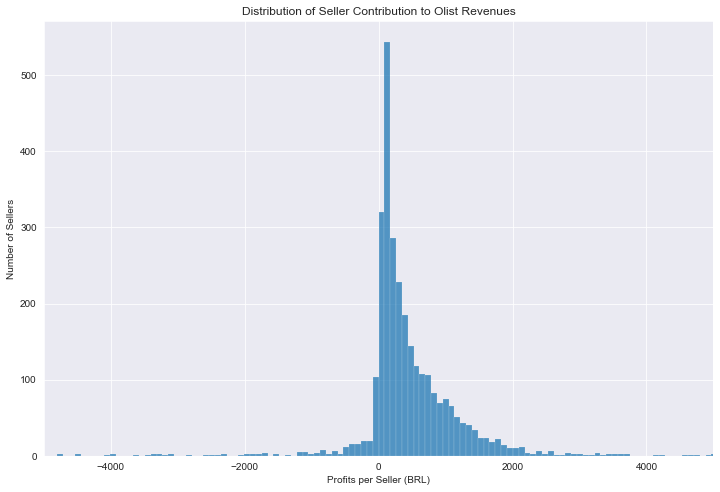

In [12]:
plt.figure(figsize=(12,8))
sns.set_style('darkgrid')
ax = sns.histplot(sellers.profit_per_seller)
ax.set_xlim(xmin=-5000, xmax=5000)
ax.set_xlabel('Profits per Seller (BRL)')
ax.set_ylabel('Number of Sellers')
ax.set_title('Distribution of Seller Contribution to Olist Revenues');

In [13]:
sellers.profit_per_seller.describe()

count     2970.000000
mean       424.055631
std       1274.295160
min     -22419.517000
25%         93.000000
50%        285.790500
75%        720.593750
max      17967.605000
Name: profit_per_seller, dtype: float64

**Interpretation of Results**

From our plot and summary stats of profits to Olist by sellers, it looks as though the middle 50% of sellers on the platform generate anywhere from 93 to 721 BRL (17 to 134 USD). However, we can see that there are some sellers with a negative impact on profits. 

Let's see if we can find out:
1. How many sellers have a negative impact on profits?
2. What would be the difference for Olist if these sellers were removed?
3. Is there a reasonable threshold we could set before removing poor performers (e.g. after 'x' number of months on platform if 'x' number of bad reviews, etc.)?

#### How many sellers are negatively impacting Olist profits?

Let's make a bar plot to see that more clearly.

In [18]:
# Simple function to create column indicating whether sellers have positive or negative impact on profits
def olist_impact(x):
    if x < 0:
        return 'negative'
    else:
        return 'positive'

sellers['impact'] = sellers['profit_per_seller'].apply(olist_impact)
sellers['impact'].value_counts()

positive    2694
negative     276
Name: impact, dtype: int64

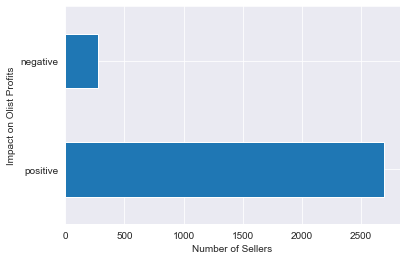

In [20]:
# Bar plot---MAYBE USE STACKED BARPLOT TO BETTER SHOW THIS?
ax1 = sellers['impact'].value_counts().plot.barh()
ax1.set_ylabel('Impact on Olist Profits')
ax1.set_xlabel('Number of Sellers');

From our bar plot and stats summary, we see that there are **276 sellers** (or roughly 10% of all sellers) who negatively impact Olist profits.

#### Impact on Olist profits if poor performing sellers removed

# STEP 2: SORT SELLERS
Step ② We can then sort sellers by increasing profits for Olist, and for each number of sellers to remove, 
compute the financial impact it would have made had they never been accepted on the platform. 
We may find an optimal number of sellers to remove that maximizes Olist's profit margin


In [ ]:
#---Probably not needed
# number of sellers that are a cost (negative profits) on Olist
# sellers_neg_profits = sellers.loc[sellers['profit_per_seller']<0].shape[0]
# sellers_neg_profits

NEW SECTION

Let's see what Olist profits would like like if these sellers were removed. One approach is to create a 'whale' curve which shows the percentage of our sellers that represent 'x' percentage of cumulative profits. 




In [77]:
# Sort sellers by how much profit each contributes to Olist (from most to least)
sellers.sort_values('profit_per_seller', ignore_index=True, inplace=True, ascending=False)

# Calculate cumulative profits to Olist with each additional seller (sorted from most to least)
sellers['accumulated_profits'] = sellers['profit_per_seller'].cumsum()
sellers.tail(20)

,seller_id,seller_city,seller_state,delay_to_carrier,seller_wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,n_orders,quantity,quantity_per_order,sales,revenue_per_seller,profit_per_seller,impact,accumulated_profits,percent_profits,seller_proportion
2950,92eb0f42c21942b6552362b9b114707d,sao paulo,SP,0.000000,13.478277,2017-02-05 19:01:53,2018-08-23 19:05:26,19.0,0.126100,0.513196,...,341,365,1.070381,6548.63,2174.863,-3985.137,negative,1435993.874,114.017970,99.360269
2951,d91fb3b7d041e83b64a00a3edfb37e4f,praia grande,SP,0.000000,11.286406,2017-02-09 02:43:25,2018-08-24 18:15:09,19.0,0.124113,0.585106,...,535,565,1.056075,40889.74,5608.974,-4031.026,negative,1431962.848,113.697906,99.393939
2952,88460e8ebdecbfecb5f9601833981930,maringa,PR,0.690747,18.267569,2017-11-21 17:58:25,2018-08-17 07:10:36,9.0,0.271654,0.409449,...,248,311,1.254032,31546.55,3874.655,-4485.345,negative,1427477.503,113.341770,99.427609
2953,3d871de0142ce09b7081e2b9d1733cb1,campo limpo paulista,SP,0.000000,13.420825,2017-03-06 02:05:14,2018-08-28 04:10:19,18.0,0.089732,0.560592,...,1080,1148,1.062963,94914.20,10931.420,-4528.580,negative,1422948.923,112.982200,99.461279
2954,128639473a139ac0f3e5f5ade55873a5,maringa,PR,0.000000,14.412933,2017-05-12 23:25:11,2018-08-21 04:35:32,16.0,0.080675,0.570356,...,533,560,1.050657,11908.85,2470.885,-4739.115,negative,1418209.808,112.605914,99.494949
2955,897060da8b9a21f655304d50fd935913,ribeirao preto,SP,0.000000,14.862096,2016-10-05 03:08:27,2018-06-14 15:38:55,21.0,0.209375,0.431250,...,317,434,1.369085,23023.92,3982.392,-4777.608,negative,1413432.200,112.226572,99.528620
2956,2138ccb85b11a4ec1e37afbd1c8eda1f,sao paulo,SP,0.000000,11.263820,2016-10-06 03:10:33,2018-08-28 13:44:54,23.0,0.148615,0.539043,...,396,430,1.085859,12357.03,3075.703,-5074.297,negative,1408357.903,111.823673,99.562290
2957,1ca7077d890b907f89be8c954a02686a,santana de parnaiba,SP,0.000000,15.028811,2017-09-15 14:10:19,2018-04-10 22:29:39,7.0,0.539130,0.200000,...,115,137,1.191304,13341.57,1894.157,-5235.843,negative,1403122.060,111.407946,99.595960
2958,1900267e848ceeba8fa32d80c1a5f5a8,ibitinga,SP,0.000000,12.795229,2017-05-19 11:05:17,2018-08-26 20:24:09,16.0,0.154589,0.490338,...,411,532,1.294404,24982.53,3778.253,-5661.747,negative,1397460.313,110.958403,99.629630
2959,2eb70248d66e0e3ef83659f71b244378,campinas,SP,0.000000,17.974677,2018-02-07 11:55:46,2018-07-19 00:55:28,6.0,0.413793,0.231527,...,202,213,1.054455,42628.61,4742.861,-5737.139,negative,1391723.174,110.502874,99.663300


In [32]:
# total profits for Olist
total_profits = sellers['accumulated_profits'].iloc[-1]
total_profits

1259445.2239999846

In [82]:
# Calculate percent of profits that each seller contributes
sellers['percent_profits'] = sellers['accumulated_profits'].div(total_profits).mul(100)

# Calculate the proportion of sellers on platform (in percent) 
sellers['seller_proportion'] = (sellers.index+1) / sellers.seller_id.count() * 100

whale_df = sellers[['seller_id', 'percent_profits', 'seller_proportion']]
whale_df.head()

,seller_id,percent_profits,seller_proportion
0,53243585a1d6dc2643021fd1853d8905,1.426629,0.03367
1,7e93a43ef30c4f03f38b393420bc753a,2.586122,0.06734
2,fa1c13f2614d7b5c4749cbc52fecda94,3.717906,0.10101
3,edb1ef5e36e0c8cd84eb3c9b003e486d,4.296610,0.13468
4,ccc4bbb5f32a6ab2b7066a4130f114e3,4.834979,0.16835


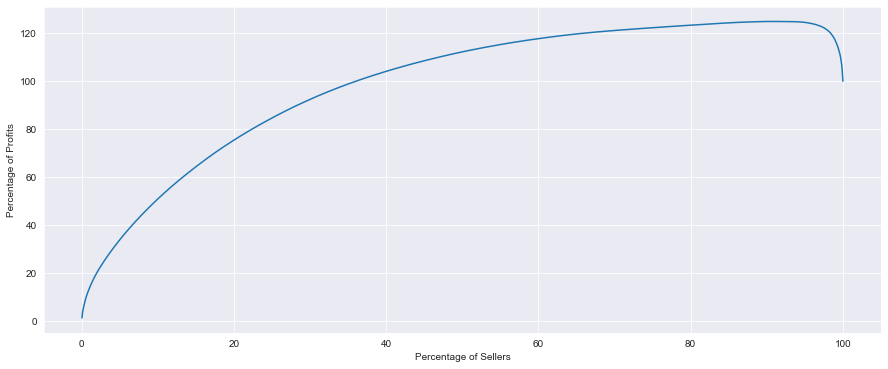

In [89]:
plt.figure(figsize=(15,6))
sns.lineplot(data=sellers, x='seller_proportion', y='percent_profits')
plt.xlabel('Percentage of Sellers')
plt.ylabel('Percentage of Profits');

Our whale curve helps to underscore that the poorest performing ~10% of sellers put downward pressure on Olist profits 

In [112]:
# Amount of reduction in profits due to poor performers
neg_profits = sellers[sellers['impact']=='negative'].profit_per_seller.cumsum()
neg_profits.iloc[-1]

-313276.50200000097

Let's do a quick bar chart to see the difference in profits without these sellers

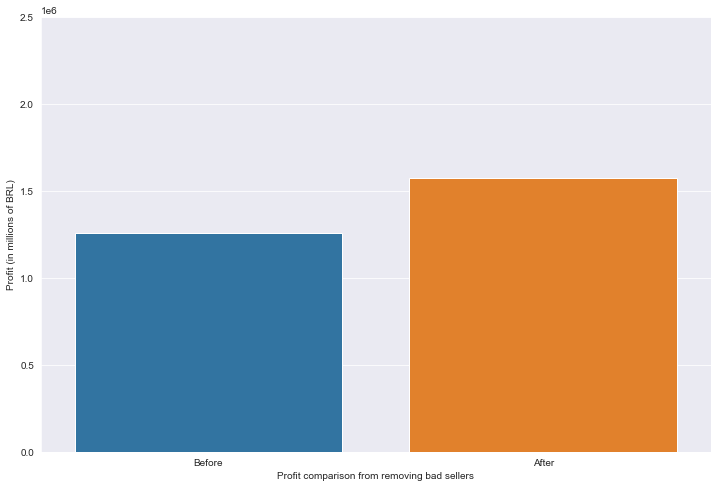

In [124]:
# Bar chart showing profit comparison after removal of poor sellers

plt.figure(figsize=(12,8))
x_values = ['Before', 'After']
y_values = [sellers.accumulated_profits.iloc[-1], sellers.accumulated_profits.iloc[-1] - neg_profits.iloc[-1]]
sns.barplot(data=sellers, x=x_values, y=y_values)
plt.ylabel('Profit (in millions of BRL)')
plt.ylim(0, 2500000)
plt.xlabel('Profit comparison from removing bad sellers');




If Olist were to drop sellers that had a negative impact on profits, the platform would see an immediate boost in profits of **313,277 BRL** ($58,246 USD) 

#### What's the impact if we factor in IT costs?

FROM PROBLEM STATEMENT

In addition, Olist’s IT costs (servers, etc…) increase with the amount of orders processed, albeit less and less rapidly (scale effects).
For the sake of simplicity, we will consider Olist’s total cumulated IT Costs to be proportional to the square-root of the total cumulated number of orders approved.
#The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to 500,000 BRL.

In [ ]:
#Profits per number of sellers removed [DO AFTER FACTOR IN IT COSTS]


In [ ]:
sellers.head(5)

We are told that IT costs (servers, etc.) increase with the number of orders processed, but due to economies of scale, the marginal cost descrease per order. To keep things simple, we're told that the total cumulated IT costs is proportional to the square-root of the total cumulated number of approved orders. Additionally, the IT department has informed us that so far accumulated IT costs since founding of the company have amounted to 500,000 BRL (~USD 92,930).

In [ ]:
#IT Costs 
#Proportionality coefficient(B) of 0.028 based on integral of B*(n_orders)**1/2 = 500000
sellers['accumulated_orders'] = sellers['n_orders'].cumsum()
sellers['it_cost'] = (sellers['accumulated_orders']**0.5)*0.028
sellers.tail(5)

In [ ]:
#IT Unit Cost

sellers['it_unit_cost'] = sellers['it_cost'].diff()




In [ ]:
#Profits per number of sellers removed [DO AFTER FACTOR IN IT COSTS]
sellers['olist_profits'] = sellers['profit_per_seller'] - sellers['it_cost']
sellers.loc[2680:2690]

In [ ]:
sellers['olist_profits'][10:700].plot(figsize=(15,8));

In [ ]:
sellers['olist_profits'].plot(figsize=(15,8));

In [ ]:
sellers.loc[50:100, :]

In [ ]:
sellers['n_orders'].sort_values()

# Recommendation: 

## Remove poorest performing sellers on Olist platform for immediate profit increase

## Profit Analysis

- 280 poorest-performing sellers have negative impact on profits
- Top 100 highest performing sellers comprise bulk of profits

In [ ]:
# If sellers ordered by level of contribution to Olist profits

sellers['olist_profits'].plot(figsize=(15,7))
plt.xlabel('Number of Sellers')
plt.ylabel('Profit (BRL)')
plt.show()


## Profit Analysis

- Immediate profit increase of 320K BRL

In [ ]:
x_values = ['Before', 'After']
y_values = [1.25, 1.57]
plt.bar(x_values, y_values)
plt.ylabel('Profit (Millions of BRL)')
plt.ylim(0, 2)
plt.show()


## IT Cost Concerns 

- Increase in marginal costs due to drop in sellers negligible
- Some poorest-performing sellers contribute to larger share of IT cost burden


In [ ]:
sellers['it_cost'].plot(figsize=(15,7))
plt.xlabel('Number of Sellers')
plt.ylabel('IT Cost per Seller (BRL)')
plt.show()


In [ ]:
sellers['it_cost'][10:700].plot()

In [ ]:
ax1 = sellers['it_cost'].plot()
ax1.set(xlim=[0,3000], ylim=[-1000,2000])

ax2 = sellers['olist_profits'].plot()
ax2.set(xlim=[0,3000], ylim=[-1000,2000])
plt.xlabel['']




## Areas to Explore Further

- Evaluate whether can improve average seller performance
- Explore reviews for cause of dissatisfaction